### Import's

In [50]:
import pandas as pd
import statistics
from collections import Counter
import matplotlib.pyplot as plt

### Lendo arquivo csv

In [51]:
## Ler o arquivo csv, e ler apenas as colunas ['Palavras', 'Rotulo', 'Sentenca']
## df_original = pd.read_csv("./Divergencias.csv", usecols=['Palavras', 'Rotulo', 'Sentenca'])
df_original = pd.read_csv("./FinalDataSetWith_InitialAndFinalPositionOfWordsInPhrase.csv", usecols=['Palavras', 'Rotulo', 'Sentenca'])

In [52]:
display(df_original)

,Palavras,Rotulo,Sentenca
0,id,O,1
1,:,O,1
2,0,O,1
3,NOME,O,2
4,DA,O,2
...,...,...,...
186014,Destilados,O,13858
186015,do,O,13858
186016,Brasil,B-NOME_LOCAL,13858
186017,2019,B-TEMPO,13858


#### Visualizando os tipos do elementos no DataFrame

In [53]:
display(df_original.dtypes)

Palavras    object
Rotulo      object
Sentenca     int64
dtype: object

In [54]:
display(df_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186019 entries, 0 to 186018
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Palavras  186019 non-null  object
 1   Rotulo    186019 non-null  object
 2   Sentenca  186019 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


None

### Filtrando e pegando as informações de instâncias

#### Inicializando as variaveis
Essas variaveis ajudarão na construção das estatisticas!

In [55]:
index_remove = []
lista_tokens_por_inst = [] ## Lista para armazenar tokens por instâncias
cont_tokens = 0
lista_sentencas_por_inst_original = [[0,0]] ## Lista para armazenar tokens por instâncias, com valor presetado (o padrão é [<sentença atual>,<qtd de senteças>])
lista_rotulacoes_por_inst_IOB = []
dict_rotulacoes = dict({})

#### Filtrando
Lembrete sempre execute a cedula de cima antes!

In [56]:
for index, dado in df_original.iterrows():
    try:
        if (len(dado['Palavras']) == 1 and not dado['Palavras'][0].isalnum()) and dado["Rotulo"] == 'O': ## Retirar os caracteres especiais que estão sozinhos
            index_remove.append(index)
        elif (dado['Palavras'] == 'id'): ## Retirar o id e o número que o acompanha
            index_remove.append(index)
            index_remove.append(index + 2) ## Para pegar o número do id
            lista_tokens_por_inst.append(cont_tokens) ## Adiciona os token's calculados do id anterior na lista
            cont_tokens = 0 ## Zera o contador para iniciar uma nova contagem de tokens por instância
            lista_sentencas_por_inst_original.append([0,0]) ## Inicio outra contagem de sentença por instância
            lista_rotulacoes_por_inst_IOB.append(list(dict_rotulacoes.items()))
            dict_rotulacoes = dict({})
        elif index not in index_remove:
            if dado['Sentenca'] != lista_sentencas_por_inst_original[-1][0]: ## Vejo se estou mexendo com outra sentença, caso se atualizo a sentença atual e adiciono um ao contador
                lista_sentencas_por_inst_original[-1][0] = dado['Sentenca']
                lista_sentencas_por_inst_original[-1][1] += 1
            if dado['Rotulo'] not in dict_rotulacoes.keys():
                dict_rotulacoes.update(dict({dado['Rotulo'] : 0}))
            dict_rotulacoes[dado['Rotulo']] += 1
            cont_tokens += 1 ## Incrementa um token ao contador, visto de ser um token considerado válido
    except:
        print("Houve erro na palavra: " + str(dado['Palavra']))
        break

#### Arrumando os dados das variveis

In [57]:
## Comandos para adequar as variveis para realização das estatisticas
lista_tokens_por_inst.append(cont_tokens) ## Adiciona os token's calculados do id último
lista_tokens_por_inst.pop(0) ## Retiro primeiro elemento da lista por ser um elemento sempre 0
lista_sentencas_por_inst_original.pop(0) ## Retiro primeiro elemento da lista por ser um elemento sem valor
lista_rotulacoes_por_inst_IOB.append(list(dict_rotulacoes.items()))
lista_rotulacoes_por_inst_IOB.pop(0)

[]

#### Retirando os elementos não desejados do DF original

In [58]:
df_limpa = df_original.drop(axis=0, index=index_remove)

In [59]:
display(df_limpa)

,Palavras,Rotulo,Sentenca
3,NOME,O,2
4,DA,O,2
5,CACHAÇA,O,2
7,Cachaça,O,2
8,Três,B-NOME_BEBIDA,2
...,...,...,...
186013,e,O,13858
186014,Destilados,O,13858
186015,do,O,13858
186016,Brasil,B-NOME_LOCAL,13858


### Preparando / visualizando os dados para a estatística

In [60]:
## Função para tirar o IOB das rotulações
def retira_IOB(lista_rotulacoes):
    dict_rotulacoes = dict({})
    for index, dado in enumerate(lista_rotulacoes):
        if dado[0] != 'O':
            if dado[0][2:] not in dict_rotulacoes.keys():
                dict_rotulacoes.update(dict({dado[0][2:] : 0}))
            dict_rotulacoes[dado[0][2:]] += dado[1]
        else:
            dict_rotulacoes[dado[0]] = dado[1]
    return list(dict_rotulacoes.items())

In [61]:
## Preparando para pegar tokens por setença
lista_tokens_por_sentenca = list(df_limpa.groupby(by="Sentenca")["Palavras"].count()) ## Agrupa as sentenças conto quantos tokens tem por setença e transforma em lista
## Preparando para extrair sentenças por instâncias
lista_sentencas_por_inst = [x[1] for x in lista_sentencas_por_inst_original] ## Extrai apenas a quantidade de sentenças presentes por instância
## Preparando para pegar as quantidades de rotulações
lista_qtdRotulacoes_IOB = [[x[0], x[1]["Palavras"].count()] for x in df_limpa.groupby(by="Rotulo")] ## Agrupa por rotulação e calcucula quantos tokens tem por rotulação
## Preparando para pegar as quantidades de rotulações sem IOB
lista_qtdRotulacoes = retira_IOB(lista_qtdRotulacoes_IOB)

In [62]:
## Preparando para pegar rotulações por sentença
lista_rotulos_por_sentenca_IOB = []
for dado in df_limpa.groupby(by="Sentenca"):
    lista_rotulos_por_sentenca_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [63]:
## Preparando para extrair rotulações por sentença sem IOB
lista_rotulos_por_sentenca = []
for sentenca in lista_rotulos_por_sentenca_IOB:
    lista_rotulos_por_sentenca.append([sentenca[0], retira_IOB(sentenca[1])])

In [64]:
## Preparando para extrair rotulações por instância sem IOB
lista_rotulacoes_por_inst = []
for instancia in lista_rotulacoes_por_inst_IOB:
    lista_rotulacoes_por_inst.append(retira_IOB(instancia))

In [65]:
## Preparando para pegar rotulações por token
lista_rotulacoes_por_tokens_IOB = []
for dado in df_limpa.groupby(by="Palavras"):
    lista_rotulacoes_por_tokens_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [66]:
lista_rotulacoes_por_tokens = []
for token in lista_rotulacoes_por_tokens_IOB:
    lista_rotulacoes_por_tokens.append([token[0], retira_IOB(token[1])])

In [67]:
## print(lista_tokens_por_sentenca) ## Tokens por sentença

In [68]:
## print(lista_tokens_por_inst) ## Tokens por instâncias

In [69]:
## print(lista_sentencas_por_inst) ## Setenças por instâncias

## Informações da Estatística

In [70]:
print("Quantidade de tokens removidos: " + str(len(df_original) - len(df_limpa)))

Quantidade de tokens removidos: 29995


### Dados demográficos 

In [71]:
print("-----QUANTIDADES-----")
print("Quantidade de instâncias: " + str(len(lista_tokens_por_inst)))
print("Quantidade de sentenças: " + str(len(lista_tokens_por_sentenca)))
print("Quantidade de tokens: " + str(len(df_limpa)))

-----QUANTIDADES-----
Quantidade de instâncias: 1000
Quantidade de sentenças: 12845
Quantidade de tokens: 156024


#### Rotulacoes

##### Qtd totais Rotulações  - Gráficos

In [72]:
## print(lista_qtdRotulacoes_IOB) ## Quantidade de rotulações com IOB

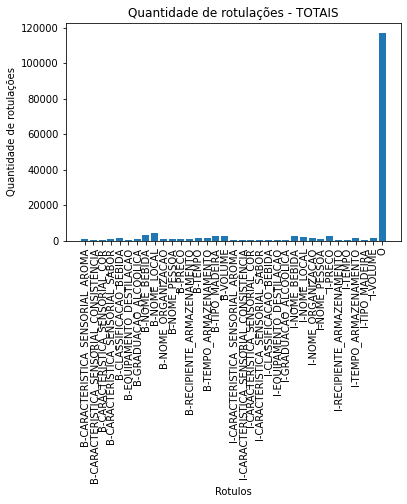

In [73]:
grupos = [x[0] for x in lista_qtdRotulacoes_IOB]
valores = [x[1] for x in lista_qtdRotulacoes_IOB]
plt.bar(grupos, valores)
plt.title('Quantidade de rotulações - TOTAIS')
plt.ylabel('Quantidade de rotulações')
plt.xlabel('Rotulos')
plt.xticks(rotation='vertical')
plt.show()

In [74]:
## print(lista_qtdRotulacoes) ## Quantidade de rotulações

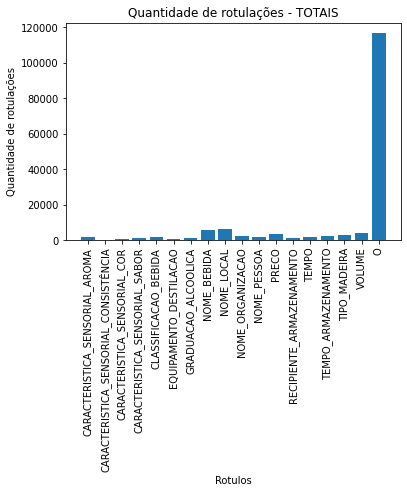

In [75]:
grupos = [x[0] for x in lista_qtdRotulacoes]
valores = [x[1] for x in lista_qtdRotulacoes]
plt.bar(grupos, valores)
plt.title('Quantidade de rotulações - TOTAIS')
plt.ylabel('Quantidade de rotulações')
plt.xlabel('Rotulos')
plt.xticks(rotation='vertical')
plt.show()

In [76]:
## print(lista_rotulos_por_sentenca_IOB) ## Quantidade de rotulações por sentença com IOB

In [77]:
## print(lista_rotulos_por_sentenca) ## Quantidade de rotulações por sentença

In [78]:
## print(lista_rotulacoes_por_inst_IOB) ## Quantidade de rotulação por instância com IOB

In [79]:
## print(lista_rotulacoes_por_inst) ## Quantidade de rotulação por instância

In [80]:
## print(lista_rotulacoes_por_tokens_IOB) ## Quantidade de rotulações por tokens com IOB

In [81]:
## print(lista_rotulacoes_por_tokens) ## Quantidade de rotulações por tokens

### TOKENS POR SENTENÇA

In [82]:
print("-----QUANTIDADES-----")
print("Quantidade de sentenças: " + str(len(lista_tokens_por_sentenca)))
print("Quantidade de tokens: " + str(sum(lista_tokens_por_sentenca)))
print("Quantidade máxima de tokens em uma sentença: " + str(max(lista_tokens_por_sentenca)))
print("Quantidade mínima de tokens em uma sentença: " + str(min(lista_tokens_por_sentenca)))
print("-----Médias-----")
print("Média aritmética dos tokens por sentença: " + str(statistics.mean(lista_tokens_por_sentenca)))
print("Média geométrica dos tokens por sentença: " + str(statistics.geometric_mean(lista_tokens_por_sentenca)))
print("Média harmônica dos tokens por sentença: " + str(statistics.harmonic_mean(lista_tokens_por_sentenca)))
print("-----Medianas-----")
print("Mediana dos tokens por setença: " + str(statistics.median(lista_tokens_por_sentenca)))
print("Mediana inferior dos tokens por setença: " + str(statistics.median_low(lista_tokens_por_sentenca)))
print("Mediana superior dos tokens por setença: " + str(statistics.median_high(lista_tokens_por_sentenca)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por setença: " + str(statistics.median_grouped(lista_tokens_por_sentenca)))
print("-----Moda-----")
print("Moda dos tokens por sentença: " + str(statistics.mode(lista_tokens_por_sentenca)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por sentença: " + str(statistics.pstdev(lista_tokens_por_sentenca)))
print("Desvio padrão amostral dos tokens por sentença: " + str(statistics.stdev(lista_tokens_por_sentenca)))
print("-----Variância-----")
print("Variância populacional dos tokens por sentença: " + str(statistics.pvariance(lista_tokens_por_sentenca)))
print("Variância amostral dos tokens por sentença: " + str(statistics.variance(lista_tokens_por_sentenca)))
print("-----Quantiles-----")
print("Quantiles dos tokens por sentença: " + str(statistics.quantiles(lista_tokens_por_sentenca)))

-----QUANTIDADES-----
Quantidade de sentenças: 12845
Quantidade de tokens: 156024
Quantidade máxima de tokens em uma sentença: 477
Quantidade mínima de tokens em uma sentença: 1
-----Médias-----
Média aritmética dos tokens por sentença: 12.146671856753601
Média geométrica dos tokens por sentença: 7.585861653723629
Média harmônica dos tokens por sentença: 5.161823296472544
-----Medianas-----
Mediana dos tokens por setença: 7
Mediana inferior dos tokens por setença: 7
Mediana superior dos tokens por setença: 7
Mediana, ou o 50º percentil dos dados agrupados dos tokens por setença: 6.954623287671233
-----Moda-----
Moda dos tokens por sentença: 3
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por sentença: 17.98645671507439
Desvio padrão amostral dos tokens por sentença: 17.98715689051172
-----Variância-----
Variância populacional dos tokens por sentença: 323.51262516324454
Variância amostral dos tokens por sentença: 323.53781300388323
-----Quantiles-----
Quantiles dos token

#### Gráficos

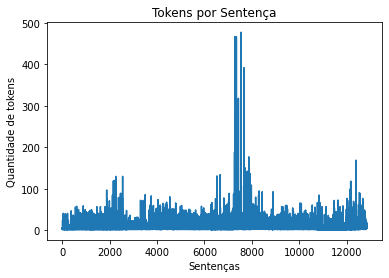

In [84]:
plt.plot([x for x in range(len(lista_tokens_por_sentenca))], lista_tokens_por_sentenca)
plt.title("Tokens por Sentença")
plt.ylabel('Quantidade de tokens')
plt.xlabel('Sentenças')
plt.show()

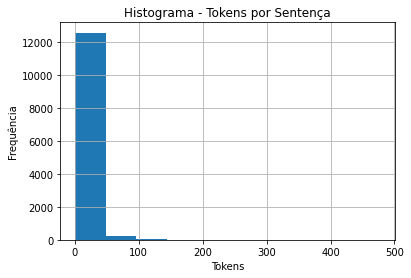

In [85]:
plt.hist(lista_tokens_por_sentenca)
plt.xlabel('Tokens')
plt.ylabel('Frequência')
plt.title('Histograma - Tokens por Sentença')
plt.grid()
plt.show()

### TOKENS POR INSTÂNCIA

In [86]:
print("-----QUANTIDADES-----")
print("Quantidade de instâncias: " + str(len(lista_tokens_por_inst)))
print("Quantidade de tokens: " + str(sum(lista_tokens_por_inst)))
print("Quantidade máxima de tokens em uma instância: " + str(max(lista_tokens_por_inst)))
print("Quantidade mínima de tokens em uma instância: " + str(min(lista_tokens_por_inst)))
print("-----Médias-----")
print("Média aritmética dos tokens por instância: " + str(statistics.mean(lista_tokens_por_inst)))
print("Média geométrica dos tokens por instância: " + str(statistics.geometric_mean(lista_tokens_por_inst)))
print("Média harmônica dos tokens por instância: " + str(statistics.harmonic_mean(lista_tokens_por_inst)))
print("-----Medianas-----")
print("Mediana dos tokens por instância: " + str(statistics.median(lista_tokens_por_inst)))
print("Mediana inferior dos tokens por instância: " + str(statistics.median_low(lista_tokens_por_inst)))
print("Mediana superior dos tokens por instância: " + str(statistics.median_high(lista_tokens_por_inst)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: " + str(statistics.median_grouped(lista_tokens_por_inst)))
print("-----Moda-----")
print("Moda dos tokens por instância: " + str(statistics.mode(lista_tokens_por_inst)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por instância: " + str(statistics.pstdev(lista_tokens_por_inst)))
print("Desvio padrão amostral dos tokens por instância: " + str(statistics.stdev(lista_tokens_por_inst)))
print("-----Variância-----")
print("Variância populacional dos tokens por instância: " + str(statistics.pvariance(lista_tokens_por_inst)))
print("Variância amostral dos tokens por instância: " + str(statistics.variance(lista_tokens_por_inst)))
print("-----Quantiles-----")
print("Quantiles dos tokens por instância: " + str(statistics.quantiles(lista_tokens_por_inst)))

-----QUANTIDADES-----
Quantidade de instâncias: 1000
Quantidade de tokens: 156024
Quantidade máxima de tokens em uma instância: 805
Quantidade mínima de tokens em uma instância: 14
-----Médias-----
Média aritmética dos tokens por instância: 156.024
Média geométrica dos tokens por instância: 120.56283251415897
Média harmônica dos tokens por instância: 93.09696192162718
-----Medianas-----
Mediana dos tokens por instância: 119.0
Mediana inferior dos tokens por instância: 119
Mediana superior dos tokens por instância: 119
Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: 119.0
-----Moda-----
Moda dos tokens por instância: 99
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por instância: 119.55740639542161
Desvio padrão amostral dos tokens por instância: 119.61722997004112
-----Variância-----
Variância populacional dos tokens por instância: 14293.973424
Variância amostral dos tokens por instância: 14308.281705705705
-----Quantiles-----
Quantiles dos tok

#### Gráficos

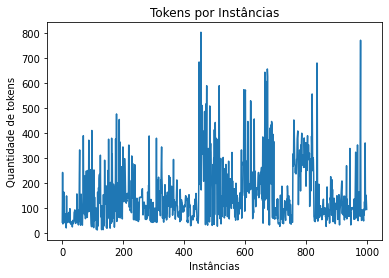

In [87]:
plt.plot([x for x in range(len(lista_tokens_por_inst))], lista_tokens_por_inst)
plt.title("Tokens por Instâncias")
plt.ylabel('Quantidade de tokens')
plt.xlabel('Instâncias')
plt.show()

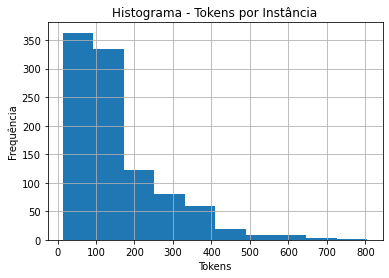

In [88]:
plt.hist(lista_tokens_por_inst)
plt.xlabel('Tokens')
plt.ylabel('Frequência')
plt.title('Histograma - Tokens por Instância')
plt.grid()
plt.show()

### SENTENÇAS POR INSTÂNCIA

In [89]:
print("-----QUANTIDADES-----")
print("Quantidade de instâncias: " + str(len(lista_sentencas_por_inst)))
print("Quantidade de sentenças: " + str(sum(lista_sentencas_por_inst)))
print("Quantidade máxima de sentenças em uma instância: " + str(max(lista_sentencas_por_inst)))
print("Quantidade mínima de sentenças em uma instância: " + str(min(lista_sentencas_por_inst)))
print("-----Médias-----")
print("Média aritmética dos tokens por instância: " + str(statistics.mean(lista_sentencas_por_inst)))
print("Média geométrica dos tokens por instância: " + str(statistics.geometric_mean(lista_sentencas_por_inst)))
print("Média harmônica dos tokens por instância: " + str(statistics.harmonic_mean(lista_sentencas_por_inst)))
print("-----Medianas-----")
print("Mediana dos tokens por instância: " + str(statistics.median(lista_sentencas_por_inst)))
print("Mediana inferior dos tokens por instância: " + str(statistics.median_low(lista_sentencas_por_inst)))
print("Mediana superior dos tokens por instância: " + str(statistics.median_high(lista_sentencas_por_inst)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: " + str(statistics.median_grouped(lista_sentencas_por_inst)))
print("-----Moda-----")
print("Moda dos tokens por instância: " + str(statistics.mode(lista_sentencas_por_inst)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por instância: " + str(statistics.pstdev(lista_sentencas_por_inst)))
print("Desvio padrão amostral dos tokens por instância: " + str(statistics.stdev(lista_sentencas_por_inst)))
print("-----Variância-----")
print("Variância populacional dos tokens por instância: " + str(statistics.pvariance(lista_sentencas_por_inst)))
print("Variância amostral dos tokens por instância: " + str(statistics.variance(lista_sentencas_por_inst)))
print("-----Quantiles-----")
print("Quantiles dos tokens por instância: " + str(statistics.quantiles(lista_sentencas_por_inst)))

-----QUANTIDADES-----
Quantidade de instâncias: 1000
Quantidade de sentenças: 12845
Quantidade máxima de sentenças em uma instância: 45
Quantidade mínima de sentenças em uma instância: 3
-----Médias-----
Média aritmética dos tokens por instância: 12.845
Média geométrica dos tokens por instância: 11.103724193894154
Média harmônica dos tokens por instância: 9.569715293663574
-----Medianas-----
Mediana dos tokens por instância: 11.0
Mediana inferior dos tokens por instância: 11
Mediana superior dos tokens por instância: 11
Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: 10.888059701492537
-----Moda-----
Moda dos tokens por instância: 9
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por instância: 7.043789817988609
Desvio padrão amostral dos tokens por instância: 7.047314356521897
-----Variância-----
Variância populacional dos tokens por instância: 49.614975
Variância amostral dos tokens por instância: 49.664639639639645
-----Quantiles-----
Quantile

#### Gráficos

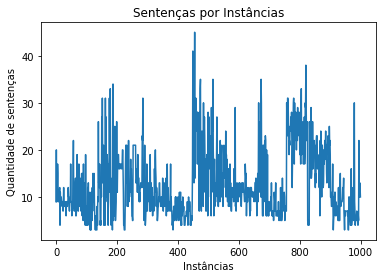

In [90]:
plt.plot([x for x in range(len(lista_sentencas_por_inst))], lista_sentencas_por_inst)
plt.title("Sentenças por Instâncias")
plt.ylabel('Quantidade de sentenças')
plt.xlabel('Instâncias')
plt.show()

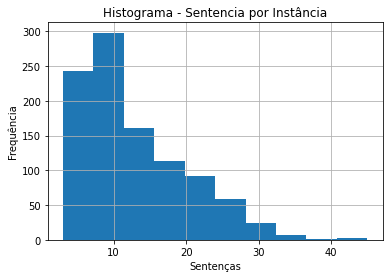

In [91]:
plt.hist(lista_sentencas_por_inst)
plt.xlabel('Sentenças')
plt.ylabel('Frequência')
plt.title('Histograma - Sentencia por Instância')
plt.grid()
plt.show()

# Testes / Exemplos / Demonstração

### Calculando desvio padrão

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().std())

### Calculando moda

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().mode())

### Calculando Mediana

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().median())

### Cálculo da média com desvio padrão

###### OBS: o cálculo está trabalhando com os valores de tokens por sentença!
O cálculo a seguir irá realizar a seguinte operação:
média + (multiplicador * desvio_padrão)
posteriormente a este cálculo teremos um valor cabeça, e apartir dele iremos quantificar quantas senteças possuem uma quantidade de tokens maiores que o valor cabeça calculado. Tendo em mãos a quantidade de sentenças é calculado a porcetagem que essa quantidade representa ao todo de sentenças.

In [ ]:
multiplicador = 1 ## Valor a ser alterado para validar em outros casos
valor = df_limpa.groupby(by="Sentenca")["Palavras"].count().mean() + multiplicador * df_limpa.groupby(by="Sentenca")["Palavras"].count().std()
print("A média mais o desvio padrão vezes " + str(multiplicador) + " resultou no valor: " + str(valor))
resultado = len(list(filter(lambda x : x > valor, list(df_limpa.groupby(by="Sentenca")["Palavras"].count()))))
print("A quantidade de sentenças que possui mais de " + str(valor) + " tokens é de: " + str(resultado))
print("Que representa um total de " + str((resultado / len(df_limpa.groupby(by="Sentenca"))) * 100) + "% das setenças, de um toltal de: " + len(df_limpa.groupby(by="Sentenca")))

### Imprimindo as setenças que possuem apenas 1 token

In [92]:
teste = [index for index, num in enumerate(df_limpa.groupby(by="Sentenca")["Palavras"].count()) if num == 1]
palavras_lista = list(df_limpa.groupby(by="Sentenca")["Palavras"])
print("Quantidade de sentenças com 1 token: " + str(len(teste)))
for index in teste:
    print(palavras_lista[index][1])

Quantidade de sentenças com 1 token: 153
14818    Experimente
Name: Palavras, dtype: object
23532    Experimente
Name: Palavras, dtype: object
26294    Experimente
Name: Palavras, dtype: object
36112    500ml
Name: Palavras, dtype: object
53317    Saúde
Name: Palavras, dtype: object
54189    Extraordinária
Name: Palavras, dtype: object
87848    Exclusiva
Name: Palavras, dtype: object
87850    Superlativa
Name: Palavras, dtype: object
89871    Local
Name: Palavras, dtype: object
133356    Premium
Name: Palavras, dtype: object
135457    Overpriced
Name: Palavras, dtype: object
135459    Talvez
Name: Palavras, dtype: object
135464    Talvez
Name: Palavras, dtype: object
162075    Madeira
Name: Palavras, dtype: object
162079    Tipo
Name: Palavras, dtype: object
162080    Origem
Name: Palavras, dtype: object
162101    Volume:700ml
Name: Palavras, dtype: object
162299    Origem
Name: Palavras, dtype: object
162532    prata
Name: Palavras, dtype: object
162544    Tipo
Name: Palavras, dtype: 

### Teste
Teste feito em ambiente menor.

In [ ]:
df_teste = df_limpa.loc[0:20]

In [ ]:
display(df_teste)

In [ ]:
print(list(df_teste.groupby(by="Sentenca")["Palavras"].count()))

In [ ]:
print(df_teste.groupby(by="Sentenca")["Palavras"].count().mean())

In [ ]:
print(df_teste.groupby(by="Sentenca")["Palavras"].count().std())

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().mode())

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().median())

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lista_setenca_qtdTokens, len(lista_setenca_qtdTokens))

plt.grid(True)
plt.show()

In [ ]:
for dado in df_limpa.groupby(by=["Sentenca"], dropna=False)["Palavras"].count():
    print(dado)

In [ ]:
print(lista_rotulacoes_inst)

In [ ]:
lista_rotulacoes_por_tokens = []
for dado in df_limpa.groupby(by="Palavras"):
    lista_rotulacoes_por_tokens.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [ ]:
print(lista_rotulacoes_por_tokens)

In [ ]:
## Preparando para pegar rotulações por sentença
lista_rotulos_por_sentenca_IOB = []
for dado in df_limpa.groupby(by="Sentenca"):
    lista_rotulos_por_sentenca_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [ ]:
print(teste)

In [ ]:
print(lista_rotulos_por_sentenca_IOB)

In [44]:
teste = [[x] for x in lista_tokens_por_sentenca]

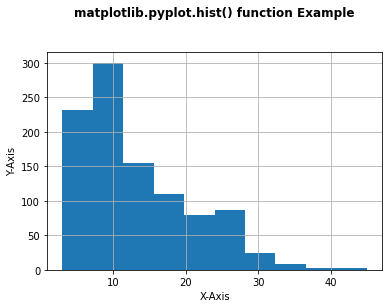

In [40]:
plt.hist(lista_sentencas_por_inst)
plt.xlabel('Sentenças')
plt.ylabel('Frequência')
plt.title('Histograma - Sentencia por Instância')
plt.grid()
plt.show()